## Assignment 2 :
 Rony Avivi & Avigail shahar

In [1]:
import pandas as pd
import numpy as np
import sklearn as sklearn
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image, display
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers
from keras.backend import clear_session
from keras import metrics, optimizers, losses

import zipfile as zipfile
from zipfile import ZipFile

Mount to google drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract the zip file with the data:

In [3]:
with ZipFile('drive/MyDrive/Colab Notebooks/Data_assignment_2/cats_and_dogs_data.zip','r') as zipObj:
  zipObj.extractall('drive/MyDrive/Colab Notebooks/Data_assignment_2/all_data')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's begin by getting the data:

In [5]:
x_train_path = 'drive/MyDrive/Colab Notebooks/Data_assignment_2/all_data/content/data/X_train.npy'
y_train_path = 'drive/MyDrive/Colab Notebooks/Data_assignment_2/all_data/content/data/Y_train.npy'
x_test_path = 'drive/MyDrive/Colab Notebooks/Data_assignment_2/all_data/content/data/X_test.npy'
y_test_path = 'drive/MyDrive/Colab Notebooks/Data_assignment_2/all_data/content/data/Y_test.npy'

In [6]:
x_train = np.load(x_train_path)
y_train = np.load(y_train_path)
x_test = np.load(x_test_path)
y_test = np.load(y_test_path)

In [7]:
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)


We'll continue by exploring the data.

In [8]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of x_train is: (3200, 180, 180, 3)
Shape of y_train is: (3200,)
Shape of x_test is: (800, 180, 180, 3)
Shape of y_test is: (800,)


In [9]:
img_size = (180,180)
num_classes = 2

In [10]:
assert x_train.shape == (3200, 180, 180, 3)

We can see that each sample is a RGB image of size 180X180 pixels.

In [11]:
np.min(x_train), np.max(x_train), x_train.dtype

(0.0, 255.0, dtype('float64'))

Each pixel has float values ranging from 0 to 255.



In [12]:
np.min(y_train), np.max(y_train), y_train.dtype

(0.0, 1.0, dtype('float64'))

We can see that ther are 2 labels 0 & 1.

Let's normalize the data by dividing it with its maximal value:

In [13]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Now, let's check how the normalization changed the data:



In [14]:
np.min(x_train), np.max(x_train), x_train.dtype

(0.0, 1.0, dtype('float64'))

Let's plot some random samples with their labels:


<Figure size 432x288 with 0 Axes>

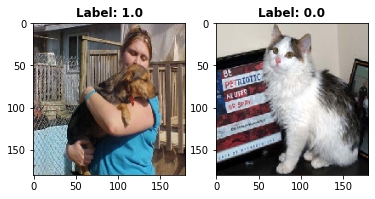

In [15]:
def plot_random_samples(x, y):

  plt.figure()
  f, axarr = plt.subplots(1, 2, gridspec_kw={'hspace':0.4}) 
  rands = np.random.randint(x.shape[0], size=10)

  axarr[0].imshow(x[rands[0], :, :])
  axarr[0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

  axarr[1].imshow(x[rands[1], :, :])
  axarr[1].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')
  
  plt.show()

plot_random_samples(x_train, y_train)

We learnd that the label 1 represents dogs and label 0 represents cats.




#Train-test-split


In [16]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/4)

We chose 1/4 as the split ratio to keep the valdiation and testing sets the same size. After this split we should have 2400 training samples, 800 testing, and 800 validation:

In [17]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)
print('Shape of x_val is:', x_val.shape)
print('Shape of y_val is:', y_val.shape)

Shape of x_train is: (2400, 180, 180, 3)
Shape of y_train is: (2400,)
Shape of x_test is: (800, 180, 180, 3)
Shape of y_test is: (800,)
Shape of x_val is: (800, 180, 180, 3)
Shape of y_val is: (800,)


# Task 1 - Creating a simple model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization

def simple_model():
    
  model = tf.keras.models.Sequential()

  # Add four convolutional layers + max pooling : 
  model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape=(180, 180, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.BatchNormalization())

  # Flatten 
  model.add(tf.keras.layers.Flatten())

  # Apply fully connected and dropout
  model.add(tf.keras.layers.Dense(128, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.5))

  # Add the output layer
  model.add(tf.keras.layers.Dense(2, activation="softmax"))

  return model

In [19]:
from keras.backend import clear_session
clear_session()
#tf.random.set_seed(42)
model = simple_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 87, 87, 32)       128       
 hNormalization)                                                 
                                                        

## Train the model : 

In [21]:
model.compile(optimizer='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - 17s 95ms/step - loss: 29.1185 - accuracy: 0.5675 - val_loss: 11.5060 - val_accuracy: 0.5063
Epoch 2/15
75/75 [==============================] - 6s 76ms/step - loss: 9.9968 - accuracy: 0.6796 - val_loss: 2.2870 - val_accuracy: 0.4950
Epoch 3/15
75/75 [==============================] - 6s 77ms/step - loss: 3.5785 - accuracy: 0.7650 - val_loss: 18.8393 - val_accuracy: 0.4900
Epoch 4/15
75/75 [==============================] - 6s 77ms/step - loss: 1.3662 - accuracy: 0.8087 - val_loss: 0.8915 - val_accuracy: 0.6050
Epoch 5/15
75/75 [==============================] - 6s 77ms/step - loss: 0.7440 - accuracy: 0.8646 - val_loss: 0.8800 - val_accuracy: 0.6050
Epoch 6/15
75/75 [==============================] - 6s 77ms/step - loss: 0.3951 - accuracy: 0.9025 - val_loss: 1.0290 - val_accuracy: 0.6500
Epoch 7/15
75/75 [==============================] - 6s 80ms/step - loss: 0.2304 - accuracy: 0.9250 - val_loss: 1.2189 - val_accuracy: 0.6600
Epoch 8/15
75/75 [==

##Results on train data :

In [22]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_train)
y_pred_labels_tr1 = np.argmax(y_pred, axis = 1)
print('Accuracy: ', accuracy_score(y_train, y_pred_labels_tr1))

75/75 [==============================] - 1s 18ms/step
Accuracy:  0.9991666666666666


##Results on test data : 

In [23]:
y_pred = model.predict(x_test)
y_pred_labels_1 = np.argmax(y_pred, axis = 1)
print('Accuracy: ', accuracy_score(y_test, y_pred_labels_1))

25/25 [==============================] - 0s 17ms/step
Accuracy:  0.72625


# Task 2 - CNN

In [24]:
def not_so_simple_model():
    
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(180, 180, 3)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.BatchNormalization())


  # Flatten 
  model.add(tf.keras.layers.Flatten())

  # Apply fully connected and dropout
  model.add(tf.keras.layers.Dense(128, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.5))

  # Add the output layer
  model.add(tf.keras.layers.Dense(2, activation="softmax"))

  return model

In [25]:
clear_session()
#tf.random.set_seed(42)
model = not_so_simple_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                        

## Train the model : 

In [27]:
model.compile(optimizer='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - 7s 72ms/step - loss: 2.0257 - accuracy: 0.5633 - val_loss: 1.6613 - val_accuracy: 0.4938
Epoch 2/15
75/75 [==============================] - 5s 61ms/step - loss: 1.3611 - accuracy: 0.6150 - val_loss: 0.6942 - val_accuracy: 0.6012
Epoch 3/15
75/75 [==============================] - 4s 54ms/step - loss: 0.9188 - accuracy: 0.6658 - val_loss: 1.0844 - val_accuracy: 0.4975
Epoch 4/15
75/75 [==============================] - 4s 58ms/step - loss: 0.7123 - accuracy: 0.7108 - val_loss: 0.9621 - val_accuracy: 0.5638
Epoch 5/15
75/75 [==============================] - 4s 54ms/step - loss: 0.5115 - accuracy: 0.7621 - val_loss: 0.9625 - val_accuracy: 0.5213
Epoch 6/15
75/75 [==============================] - 4s 54ms/step - loss: 0.4000 - accuracy: 0.8142 - val_loss: 0.8812 - val_accuracy: 0.5875
Epoch 7/15
75/75 [==============================] - 4s 54ms/step - loss: 0.3243 - accuracy: 0.8579 - val_loss: 0.7447 - val_accuracy: 0.6700
Epoch 8/15
75/75 [======

##Results on train data : 

In [28]:
y_pred = model.predict(x_train)
y_pred_labels_tr2 = np.argmax(y_pred, axis = 1)
print('Accuracy: ', accuracy_score(y_train, y_pred_labels_tr2))

75/75 [==============================] - 1s 14ms/step
Accuracy:  0.97375


##Results on test data :

In [29]:
y_pred = model.predict(x_test)
y_pred_labels_2 = np.argmax(y_pred, axis = 1)
print('Accuracy: ', accuracy_score(y_test, y_pred_labels_2))

25/25 [==============================] - 0s 13ms/step
Accuracy:  0.76375


# Task 3 - Transfer learning :

In [30]:
tf.random.set_seed(42)
base_model = tf.keras.applications.Xception(input_shape=img_size + (3,), include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


In [31]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

Assure we are not training the model on the layers that we transferred : 

In [32]:
base_model.trainable = False

Add a fully connected layer : 

In [33]:
full_model = base_model.output
full_model = tf.keras.layers.Flatten()(full_model)
output = tf.keras.layers.Dense(2, activation="softmax")(full_model)
full_model = tf.keras.Model(inputs=base_model.input, outputs=output)

Compile and train the model : 

In [34]:
clear_session()
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

## Train the model : 

In [35]:
full_model.compile(optimizer='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
full_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - 13s 133ms/step - loss: 0.5265 - accuracy: 0.9529 - val_loss: 0.7003 - val_accuracy: 0.9513
Epoch 2/10
75/75 [==============================] - 9s 126ms/step - loss: 0.2753 - accuracy: 0.9792 - val_loss: 0.3916 - val_accuracy: 0.9712
Epoch 3/10
75/75 [==============================] - 9s 124ms/step - loss: 0.0694 - accuracy: 0.9925 - val_loss: 0.2807 - val_accuracy: 0.9700
Epoch 4/10
75/75 [==============================] - 9s 125ms/step - loss: 0.0296 - accuracy: 0.9958 - val_loss: 0.4273 - val_accuracy: 0.9600
Epoch 5/10
75/75 [==============================] - 9s 120ms/step - loss: 0.0387 - accuracy: 0.9950 - val_loss: 0.3300 - val_accuracy: 0.9712
Epoch 6/10
75/75 [==============================] - 9s 116ms/step - loss: 0.0217 - accuracy: 0.9975 - val_loss: 0.3439 - val_accuracy: 0.9663
Epoch 7/10
75/75 [==============================] - 9s 115ms/step - loss: 0.0403 - accuracy: 0.9946 - val_loss: 0.4988 - val_accuracy: 0.9675
Epoch 8/10
75/75

##Results on train data : 

In [36]:
y_pred = full_model.predict(x_train)
y_pred_labels_tr3 = np.argmax(y_pred, axis = 1)
print('Accuracy: ', accuracy_score(y_train, y_pred_labels_tr3))

75/75 [==============================] - 7s 84ms/step
Accuracy:  1.0


##Results on test data : 

In [37]:
y_pred = full_model.predict(x_test)
y_pred_labels_3 = np.argmax(y_pred, axis = 1)
print('Accuracy: ', accuracy_score(y_test, y_pred_labels_3))

25/25 [==============================] - 2s 86ms/step
Accuracy:  0.97


# CSV file : 

In [39]:

results = {'model': ['Basic CNN', 'My Model', 'Xception model'],
           'Test score (Accuracy)': ['0.72625','0.76375', '0.97'],
           'Train score (Accuracy)': ['0.99','0.97375','1.0'],
           'Number of trainable parameters': ['27,639,810', '2,160,770', '147,458'],
           'Number of layers': ['6', '7', '82'],
           'Regularization methods': ['BatchNormalisation, Max pooling, Dropout', 'BatchNormalisation, Max pooling, dropout', 'BatchNormalisation, Max pooling, Dropout'],
           'Number of epochs': ['15', '15', '10'],
           'Loss function': ['SparseCategoricalCrossentropy', 'SparseCategoricalCrossentropy', 'SparseCategoricalCrossentropy'],
           'Optimizer': ['adam', 'adam', 'adam']
           }

df = pd.DataFrame(results)
df

,model,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer
0,Basic CNN,0.72625,0.99,"27,639,810",6,"BatchNormalisation, Max pooling, Dropout",15,SparseCategoricalCrossentropy,adam
1,My Model,0.76375,0.97375,"2,160,770",7,"BatchNormalisation, Max pooling, dropout",15,SparseCategoricalCrossentropy,adam
2,Xception model,0.97,1.0,"147,458",82,"BatchNormalisation, Max pooling, Dropout",10,SparseCategoricalCrossentropy,adam


In [40]:
import os
df.to_csv(os.path.join(os.getcwd(), 'assignment_2.csv'))